In [42]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.7.1


In [43]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


- dataset is of molecules and has 188 different graphs
- task: classify each graph into one out of two classes
- first graph object of the dataset comes with 17 nodes and 7 dimensional feature vecotrs, 38 edges, and only one graph label y=[1]
- there are also 4-dimensional edge features edge_attr=[38, 4]
- this exercise will only use 1 of the edge features
- we can shuffle the dataset and use the first 150 graphs as training graphs and use the remaining ones for testing

In [44]:
torch.manual_seed(12345)
dataset = dataset.shuffle()
train_dataset = dataset[:150]
test_dataset = dataset[150:]

# print(f'Num of training graphs: {len(train_dataset)}')
# print(f'Num of training graphs: {len(test_dataset)}')

## mini-batching of graphs
- we can batch graphs in graph classification because they are usually small and so we can achieve full GPU utilization
- usually you would rescale or padd each example into a set of equally-sized shapes and examples are grouped in an additional dimension and refered to the batch_size, however, this is not very feasible for GNNs
- instead, adjacency matrices are stacked in diagonal fasion and node and target features are simply concatenated in the node dimension  

there are following advantages to using this:  
(1) GNN opterators that rely on a message passing scheme does not need to be modified since messages are not exchanged between two nodes that belong to different graphs  
(2) there is no computational or memory overhead since adjacency matrices are saved in a sparse fashion, holding only non-zero entries, i.e. the edges  
- PyG also automatically takes care of batching multiple graphs into a single giant graph using the torch_geometric.data.DataLoader class

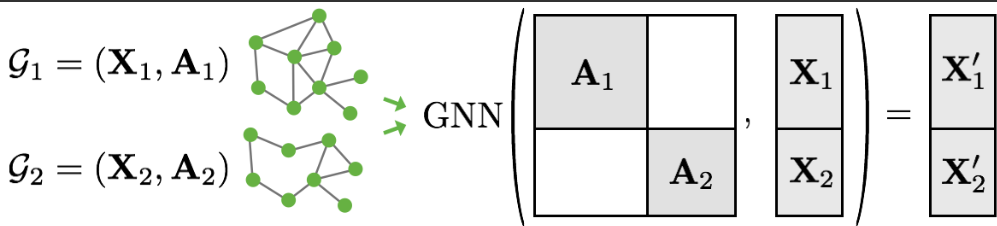

In [45]:
from IPython import display
display.Image('/Users/tuyennguyen/Desktop/Career:Job/Code/Deep_Learning_Review_and_Practice/Week1/gnn/actually_using_reources_given_to_me/Screenshot 2025-06-20 at 2.23.27 PM.png')

In [46]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f"Step {step +1}:")
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



- each Batch object has a batch vector mapping each node to its respective graph in the batch

##training a GNN  
(1) embed each node by performing multiple rounds of message passing  
(2) aggregate node embeddings intoa  unified graph embedding (called a readout layer)  
(3) train a final classifier on the graph embedding  
  
there are many types of readout layers but the most common one is to take the average of node embeddings
- this can be achieved using torch_geometric.nn.global_mean_pool -> this takes in the node embeddings of all nodes in the mini-batch and their vector "batch" to compute a graph embedding of size [batch_size, hidden_channels] for each graph in the batch

In [47]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GraphConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        #1. obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        #2. readout layer
        x = global_mean_pool(x, batch)
        
        #3. final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x
    
model = GCN(hidden_channels=64)
print(model)


GCN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [48]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct/len(loader.dataset)


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.7467, Test Acc: 0.8158
Epoch: 006, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.8158
Epoch: 008, Train Acc: 0.7533, Test Acc: 0.7895
Epoch: 009, Train Acc: 0.7267, Test Acc: 0.8158
Epoch: 010, Train Acc: 0.7867, Test Acc: 0.8421
Epoch: 011, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7533, Test Acc: 0.8158
Epoch: 013, Train Acc: 0.7800, Test Acc: 0.7632
Epoch: 014, Train Acc: 0.7600, Test Acc: 0.7895
Epoch: 015, Train Acc: 0.8267, Test Acc: 0.8158
Epoch: 016, Train Acc: 0.8333, Test Acc: 0.8421
Epoch: 017, Train Acc: 0.7667, Test Acc: 0.8158
Epoch: 018, Train Acc: 0.8133, Test Acc: 0.8421
Epoch: 019, Train Acc: 0.8067, Test Acc: 0.8421
Epoch: 020, Train Acc: 0.8000, Test Acc: 0.8158
Epoch: 021, Train Acc: 0.8067, Test Acc: